# <u>Chapter 8</u>: Detecting Hateful and Offensive Language

The spread of hate speech and fake news are serious side effects of expanding social networks. Most of the time covered behind anonymity, social network users feel more comfortable speaking hate or disseminating fabricated information as opposed to real life when they have to confront the consequences of their saying. All major social networks conduct an enormous effort to deal with such a problem, and again, manipulating text data using machine learning is a powerful tool in this arena.

The current exercise focuses on identifying hate and offensive speech in tweets using a state-of-the-art language model and classification methods. Although there are tools for extracting tweets from the platform, we use for convenience a publicly available corpus from https://github.com/t-davidson/hate-speech-and-offensive-language.

In [31]:
import sys
import subprocess
import pkg_resources

# Find out which packages are missing.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'numpy', 'pandas', 'scikit-learn', 'matplotlib', 'seaborn', 'keras', 'tensorflow-text', 'xgboost'}
missing_packages = required_packages - installed_packages

# If there are missing packages install them.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)

Now, download the datasets.

In [ ]:
import os

# Check if the data directory already exists.
if not os.path.exists("data"):
    # URL of the zip data file to download.
    url = "https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/raw/main/chapter-08/data.zip"

    # If it doesn't exist, download the zip file.
    !wget {url}

    # Unzip the file into the "data" folder.
    !unzip -q "data.zip"

## Exploratory data analysis

Before creating a custom language model, we first need to load the instances from the tweets dataset.

In [32]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd

# Read the data from the csv file.
data = pd.read_csv('./data/labeled_data.csv')

data.sample(random_state=4)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
12946,13265,3,0,3,0,1,My Ralph Lauren jacket comes tomorrow. Im givi...


Each sample was annotated by three people who labeled each tweet as _hate_speech_=0, _offensive_language_=1, or _neither_=2. It is not uncommon to encounter disagreement among the annotators, so the class of the tweet is determined by a majority vote. In the previous example, all three annotators agreed, however. Next, we print an example for each class.

In [33]:
# Print an example for each class.
print("* Hate speech:", data.iloc[10477].tweet)
print("* Offensive speech:", data.iloc[9463].tweet)
print("* Neither offensive nor non-offensive speech:", data.iloc[20963].tweet)

* Hate speech: I hate the ghetto trash at the special school across the street from my building. All of them will grow up to be criminals.
* Offensive speech: God my tweets are so ghetto
* Neither offensive nor non-offensive speech: So many weird people in the ghetto at this time.


The code that follows shows the number of samples per each class.

In [34]:
# Print the number of examples per class.
data['category'] = data['class'].map({0: 'hate_speech', 1: 'offensive_language', 2: 'neither'})
data['category'].value_counts()

offensive_language    19190
neither                4163
hate_speech            1430
Name: category, dtype: int64

Another important issue is that the tweets do not merely consist of human text, but they can frequently contain handles, emojis, and HTML links. These are also text elements, and the following code can be used to extract this information.

In [35]:
# Extract the number handles, emojis and links in the tweets.
handles_count = data['tweet'].str.count("@[A-Za-z0-9]")
emojis_count = data['tweet'].str.count("[&#A-Za-z0-9];")
links_count = data['tweet'].str.count("http:|https:")

data['handles_count'] = handles_count
data['emoji_count'] = emojis_count
data['links_count'] = links_count

<AxesSubplot:xlabel='handles_count', ylabel='category'>

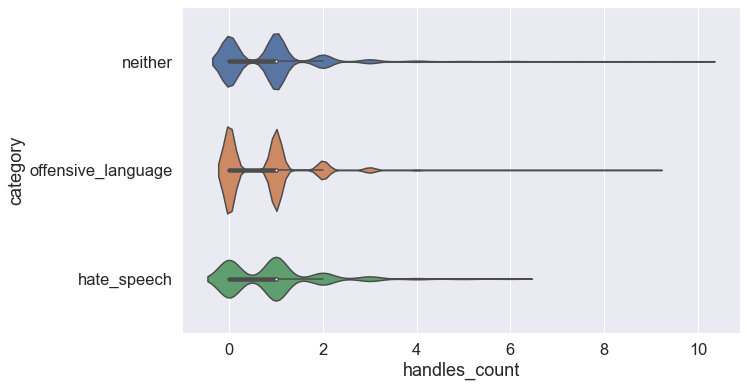

In [36]:
import matplotlib.pyplot as plt 
import seaborn as sns

# Plot the distribution of handles per category.
sns.set(font_scale=1.5)

plt.figure(figsize=(10, 6))
sns.violinplot(data=data, x='handles_count', y='category', orient='h')

The output suggests that there is a similar distribution in the three classes. For this reason, we decide to remove these extra elements using the _preprocess_text_ method.

In [37]:
import re

# Remove emojis, handles, HTML character references and links.
def preprocess_text(text):
    regrex_pattern = re.compile(pattern = "&#[A-Za-z0-9]+;|@[A-Za-z0-9]+|&[A-Za-z0-9]+;|(http|https)://[A-Za-z0-9./]+")
    return regrex_pattern.sub(r'', text)

data['tweet'] = data['tweet'].apply(lambda x: preprocess_text(x))

## BERT

The _tensorflow_hub_ module contains a gamut of `BERT` models, which are pre-trained with different datasets. In our case, the demand for smaller BERT models stems from the need to use them in smaller computational environments.

<ins>Note</ins>:  The training time will vary depending on the complexity of the BERT model you have selected.

In [38]:
tf.get_logger().setLevel('ERROR')

# Choose a BERT model to fine-tune.
model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

name_handle_dict = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

name_preprocess_dict = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

encoder_handle = name_handle_dict[model_name]
preprocess_handle = name_preprocess_dict[model_name]

print("Using the BERT model: " + encoder_handle)
print("Using the preprocess model: " + preprocess_handle)

Using the BERT model: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Using the preprocess model: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Let's now create the preprocess and BERT models.

In [39]:
import tensorflow_hub as hub
import tensorflow_text as text

# Use the handle to create the preprocess model.
preprocess_model = hub.KerasLayer(preprocess_handle)

<ins>Note</ins>: If you get the error "OSError: SavedModel file does not exist at" just delete the mentioned folder.

In [40]:
# Use the preprocess model.
text_test = ['God my tweets are so ghetto']
text_preprocessed = preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2643  2026  1056 28394  3215  2024  2061 17276   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [41]:
# Use the handle to create the BERT model.
bert_model = hub.KerasLayer(encoder_handle)

Then, we use the BERT model.

In [42]:
# Feed the text to the BERT model.
results = bert_model(text_preprocessed)

print(f'Loaded BERT: {encoder_handle}')
print("The shape of the pooled outputs:", results["pooled_output"].shape)
print(f'Pooled Outputs Values:{results["pooled_output"][0, :12]}')
print("The shape of the sequence outputs:", results["sequence_output"].shape)
print(f'Sequence Outputs Values:{results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
The shape of the pooled outputs: (1, 512)
Pooled Outputs Values:[ 0.98803324  0.8174704  -0.09931858  0.49448684  0.06150028  0.97966045
  0.981785   -0.99347323 -0.23559046 -0.9967652   0.04346502 -0.9847543 ]
The shape of the sequence outputs: (1, 128, 512)
Sequence Outputs Values:[[ 0.11464122  0.1346041   0.74873996 ... -0.03851436 -0.02120748
  -1.3489943 ]
 [-0.23390523  0.40867108  0.33201155 ...  0.7629751  -0.685918
   0.1627047 ]
 [ 0.11540073  0.1970486   0.75625384 ... -0.35113207 -0.15752485
  -0.33040127]
 ...
 [ 0.11041314 -0.46885568  0.97626245 ... -0.00837535 -0.08699548
  -1.5638739 ]
 [ 0.409267   -0.07035614  0.10864993 ...  0.43746293  0.46431613
  -0.64191353]
 [ 0.39994255 -0.04031736  0.19623217 ...  0.46916968  0.45109606
  -0.6261434 ]]


There are two keys in the _bert_results. First, the _pooled_output_ is the embedding of each tweet, while the _sequence_output_ is the contextual embedding of every token in the tweet. We use the first to represent every tweet in the dataset.



In [43]:
# Represent each tweet as an embedding.
data['pooled'] = data['tweet'].apply(lambda x: (bert_model(preprocess_model(tf.constant([x]))))["pooled_output"].numpy())

After finishing this step, we have at our disposal an extended dataset with the embeddings of the tweets.

## XGBoost

`XGBoost` stands for `eXtreme Gradient Boosting`, and it's a popular and efficient open-source implementation of the gradient boosting trees algorithm. 

Before using XGBoost, we need to split our samples into a training and a test set, using an 80:20 split.

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split

# Create the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(data['pooled'], data['class'], test_size=0.2, stratify=data['class'], random_state=123)

print("Number of samples in the training set:", len(X_train))
print("Number of samples in the test set:", len(X_test))

Number of samples in the training set: 19826
Number of samples in the test set: 4957


Next, we create the model and fit it to the training data.



In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Fit the model to the training data.
model = XGBClassifier()
model.fit(np.vstack(X_train), y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)


Finally, we can evaluate its performance.

In [46]:
# Extract the predictions using the test data.
y_pred = model.predict(np.vstack(X_test))
predictions = [round(value) for value in y_pred]

# Evaluate the predictions.
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100.0))

Accuracy: 83.92%


The obtained accuracy is impressive, considering that we didn’t apply any fine-tuning to the BERT model.

## What we have learned …

| | | |
| --- | --- | --- |
| **Visualizations**<ul><li>Violin plots</li></ul> |  **Text representations**<ul><li>BERT</li></ul> | **ML algorithms & models** <ul><li>Gradient Boosting</li><li>AdaBoost</li><li>XGBoost</li></ul> | 
| | | |

## Author Information

- **Author:** Nikos Tsourakis
- **Email:** nikos@tsourakis.net
- **Website:** [tsourakis.net](https://tsourakis.net)
- **Date:** November 20, 2023